# Data preparation
Using setlist.fm and Spotify APIs to collect historical data on setlists and artist releases. Some things we want to consider are:
1. Historical setlist data: are there some songs an artist plays at every show, even as they go through various tours?
2. Artist top tracks: The Killers, e.g., will never perform a show without playing Mr. Brightside
3. Artist recent releases: artist tours are often focused on recent material released

### 1. Import packages

In [972]:
import spotipy as spt
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from repertorio import Repertorio
import time
import ratelimit
from ratelimit import limits, sleep_and_retry
import numpy as np

### 2. API access tokens

In [1064]:
spotify_client_id = 
spotify_client_secret = 
setfm_api_key = 

### 3. Creating function to pull all setlists for a given artist
Returns a dataframe containing artist name, day of show, venue, location, setlist, indication if any songs were covers. A cover song is unlikely to be repeated and will not populate in an artist's Spotify data.

In [1948]:
setfm = Repertorio(setfm_api_key)

artist = []
date = []
venue = []
setlist_id = []
songs = []
country = []
city = []
tour = []
cover = []
cover_artist = []

def get_setlists(artist_name):

    artist_id = setfm.artists(artistName = artist_name,sort = 'relevance')['artist'][0]['mbid']
    time.sleep(1)
    num_sets = setfm.artist_setlists(artist_id)['total']
    time.sleep(1)
    for page in range(1,(num_sets // 20)+2):
        time.sleep(2)
        info = setfm.artist_setlists(artist_id, p = page)
        # number of results
        num_setlists = len(info['setlist'])
        for setlist in range(num_setlists):
            # artist name
            artist.append(info['setlist'][setlist]['artist']['name'].lower())
            # date of show
            date.append(info['setlist'][setlist]['eventDate'])
            # venue id
            venue.append(info['setlist'][setlist]['venue']['id'])
            # country
            country.append(info['setlist'][setlist]['venue']['city']['country']['code'])
            # city
            city.append(info['setlist'][setlist]['venue']['city']['name'].lower())
            # setlist id
            setlist_id.append(info['setlist'][setlist]['id'])
            # set - all songs
            song_list = []
            for num_set in range(len(info['setlist'][setlist]['sets']['set'])):
                for num_song in range(len(info['setlist'][setlist]['sets']['set'][num_set]['song'])):
                    # set - any covers
                    if 'cover' in info['setlist'][setlist]['sets']['set'][num_set]['song'][num_song] and artist_name.lower() not in info['setlist'][setlist]['sets']['set'][num_set]['song'][num_song]['cover']['name'].lower():                    
                        song_list.append([info['setlist'][setlist]['sets']['set'][num_set]['song'][num_song]['name'].lower(),1,info['setlist'][setlist]['sets']['set'][num_set]['song'][num_song]['cover']['name'].lower()])
                    else:
                        song_list.append([info['setlist'][setlist]['sets']['set'][num_set]['song'][num_song]['name'].lower(),0,''])
            songs.append(song_list)
            # tour name
            if 'tour' in info['setlist'][setlist]:
                tour.append(info['setlist'][setlist]['tour']['name'].lower())
            else:
                tour.append('')
    
    data = {'artist': artist, 'date': date, 'venue': venue, 'setlist_id': setlist_id, 'songs': songs, 
            'tour': tour, 'country': country, 'city': city}
  
    # create dataframe
    df = pd.DataFrame(data)
    return df

In [977]:
get_setlists('the killers')

,artist,date,venue,setlist_id,songs,tour,country,city,cover,cover_artist
0,the killers,14-07-2023,33d710bd,3ba704c0,"[mr. brightside, spaceman, the way it was, smi...",imploding the mirage,US,minneapolis,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[, , , , , , prince, , , , , , , , , , ]"
1,the killers,13-07-2023,63d63af7,73a7120d,"[sam's town, i could never take the place of y...",imploding the mirage,US,minneapolis,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[, prince, , , , , , , , , , , , , , , , , ]"
2,the killers,14-05-2023,4bd61fc6,73b9feb5,"[my own soul's warning, enterlude, when you we...",imploding the mirage,US,houston,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[, , , , , , , , , , , , , , , , , , , , , ]"
3,the killers,12-05-2023,1bd18590,7bb99294,"[my own soul's warning, enterlude, when you we...",imploding the mirage,US,omaha,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[, , , , , , , , , , , , , , , , , ]"
4,the killers,11-05-2023,3bd0e074,63b99a03,"[luck be a lady, sam's town, enterlude, mr. br...",imploding the mirage,US,gary,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[frank loesser, , , , , , , , , , , , , , , , ..."
...,...,...,...,...,...,...,...,...,...,...
1239,the killers,26-03-2002,63d652c7,bc37d6e,[],,US,las vegas,[],[]
1240,the killers,16-03-2002,23d43cbb,13c37d69,[],,US,las vegas,[],[]
1241,the killers,02-03-2002,4bd61b16,bc37d6a,[],,US,las vegas,[],[]
1242,the killers,12-02-2002,1bd4ed4c,5bc40b04,"[newsman, the future, under the gun, replaceable]",,US,las vegas,"[0, 0, 0, 0]","[, , , ]"


### 4. Creating function to pull artist and track details from Spotify
Returns a dataframe containing artist name, each of their tracks, track ids, indication if a track was released as a single or album, release date, popularity, track number on the album, and a list of audio features for future analysis such as "danceability" and "energy".

In [857]:
client_credentials_manager = SpotifyClientCredentials(spotify_client_id,spotify_client_secret)
sp = spt.Spotify(client_credentials_manager = client_credentials_manager)

In [1428]:
track_name_list = []
track_id_list = []
release_type_list = []
artist_list = []
album_list = []
popularity = []
release_date = []
track_number = []
audio_features = []

def get_songs(artist_name):
    
    if sp.search(q='artist:' + artist_name, type='artist', limit=1)['artists']['items'] == []:
        print('yuck')
    else:
        uri = sp.search(q='artist:' + artist_name, type='artist', limit=1)['artists']['items'][0]['id']            
        name = sp.search(q='artist:' + artist_name, type='artist', limit=1)['artists']['items'][0]['name']
        
        for release_type in ['album','single']:
            
            # pull list of albums and their album ids
            albums = sp.artist_albums(uri, album_type=release_type, limit=50, offset=0)
            album_uris = []
            for album_num in range(len(albums['items'])):
                album_uris.append(albums['items'][album_num]['uri'])

            # spotipy only pulls top 50: if there are more albums than that, we need to pull the rest
            if albums['total'] > 50:
                num_pages = albums['total'] // 50
                page = 2
                while page <= num_pages + 1:
                    albums = sp.artist_albums(uri, album_type=release_type, limit=50, offset=50*(page-1))
                    for album_num in range(len(albums['items'])):
                        album_uris.append(albums['items'][album_num]['uri'])
                    page += 1

        # pull tracklist of all songs from all albums
            for album_uri in album_uris:
                album_name = sp.album(album_uri)['name']
                for track in sp.album_tracks(album_uri)['items']:
                    # only removing duplicated track_ids, not names
                    # if a song is released as both a single and album, both will be here
                    if track['id'] not in track_id_list:
                        track_name_list.append(track['name'].lower())
                        track_id_list.append(track['id'])
                        release_type_list.append(release_type)
                        artist_list.append(name.lower())
                        album_list.append(album_name.lower())
                        track_data = sp.track(track['id'])
                        popularity.append(track_data['popularity'])
                        release_date.append(track_data['album']['release_date'])
                        track_number.append(track_data['track_number'])
                        audio_features.append(sp.audio_features(track['id'])[0])

    data = {'name': track_name_list, 
            'id': track_id_list, 
            'release_type': release_type_list,
            'artist': artist_list,
            'album': album_list,
            'popularity': popularity,
            'release_date': release_date,
            'track_number': track_number,
            'audio_features': audio_features          
           }

    # create dataframe
    df = pd.DataFrame(data)
    return df

In [1175]:
df = get_songs('the killers')

In [1176]:
df.sort_values('popularity',ascending=False)

,name,id,release_type,artist,popularity,release_date,track_number,audio_features
144,mr. brightside,003vvx7Niy0yvhvHt4a68B,album,the killers,88,2004,2,"{'danceability': 0.352, 'energy': 0.911, 'key'..."
146,somebody told me,6PwjJ58I4t7Mae9xfZ9l9v,album,the killers,81,2004,4,"{'danceability': 0.497, 'energy': 0.97, 'key':..."
133,when you were young,70wYA8oYHoMzhRRkARoMhU,album,the killers,80,2006-09-27,3,"{'danceability': 0.467, 'energy': 0.988, 'key'..."
120,human,1sTsuZTdANkiFd7T34H3nb,album,the killers,77,2008-11-18,2,"{'danceability': 0.557, 'energy': 0.8, 'key': ..."
147,all these things that i've done,5vollujufHY0jMZxx77VWr,album,the killers,74,2004,5,"{'danceability': 0.539, 'energy': 0.702, 'key'..."
...,...,...,...,...,...,...,...,...
211,somebody told me - josh harris dub,3dmghoejKD6expISEXp6pK,single,the killers,11,2004-03-15,3,"{'danceability': 0.575, 'energy': 0.964, 'key'..."
182,spaceman - lee dagger remix,4qZuRCF3Uh9pUQQ8vS2vyP,single,the killers,11,2008-11-04,3,"{'danceability': 0.681, 'energy': 0.714, 'key'..."
194,human - thin white duke dub,7nyJJwcnTHHHndygd5BQYX,single,the killers,10,2008-09-22,7,"{'danceability': 0.668, 'energy': 0.855, 'key'..."
184,spaceman - max jackson dub,0S77t5dYB299qdneiQOrkn,single,the killers,10,2008-11-04,5,"{'danceability': 0.872, 'energy': 0.58, 'key':..."


### 5. Creating a function to return an artist's top 10 tracks
Returns a dataframe with artist name, track name, track id, order of tracks. It is unlikely in my mind that an artist would ever perform a show without playing their top 1 or 2 or 3 tracks.

In [1216]:
top_track_names = []
top_track_ids = []
artists_uri = []
track_order = []

def artist_top_tracks(artist_name):
    uri = sp.search(q='artist:' + artist_name, type='artist', limit=1)['artists']['items'][0]['id']
    for song in range(10):
        top_track_names.append(sp.artist_top_tracks(uri)['tracks'][song]['name'].lower())
        top_track_ids.append(sp.artist_top_tracks(uri)['tracks'][song]['id'])
        artists_uri.append(uri)
        track_order.append(song+1)
    
    data = {'artist_id': artists_uri,
            'name': top_track_names, 
            'id': top_track_ids,
            'track_order': track_order
           }

    # create dataframe
    df = pd.DataFrame(data)
    return df

In [574]:
artist_top_tracks('the killers')

,artist_id,name,id,track_order
0,0C0XlULifJtAgn6ZNCW2eu,mr. brightside,003vvx7Niy0yvhvHt4a68B,1
1,0C0XlULifJtAgn6ZNCW2eu,somebody told me,6PwjJ58I4t7Mae9xfZ9l9v,2
2,0C0XlULifJtAgn6ZNCW2eu,when you were young,70wYA8oYHoMzhRRkARoMhU,3
3,0C0XlULifJtAgn6ZNCW2eu,human,1sTsuZTdANkiFd7T34H3nb,4
4,0C0XlULifJtAgn6ZNCW2eu,all these things that i've done,5vollujufHY0jMZxx77VWr,5
5,0C0XlULifJtAgn6ZNCW2eu,read my mind,7cX4PJz1old9fyFI8RlfgW,6
6,0C0XlULifJtAgn6ZNCW2eu,smile like you mean it,3KANrKOFYyAxfjQJHkgBdb,7
7,0C0XlULifJtAgn6ZNCW2eu,shot at the night,2aZ2Co4NeQRsqWcU930zHT,8
8,0C0XlULifJtAgn6ZNCW2eu,the man,5aWhs651KYM26HYM16kRdk,9
9,0C0XlULifJtAgn6ZNCW2eu,spaceman,1A8SxnqRK3qabmuN2qxIpa,10


# Artist selection
We now have code that creates dataframes containing large amounts of information about a given artist's songs and setlists. We now need to select a number of artists for whom to pull this data for. We need a large selection of artists with a large amount of setlist details each. We need a large range of artists: could it be that artists in different genres generally have different setlist compilation choices? How do small versus large artists compare in their setlist compilation? What about artists who are relatively new versus those that have been touring and releasing music for 50+ years?

### 1. ChatGPT to decide artists
Provided ChatGPT with the following prompts: "Please provide me 100 artists with no duplicates. I want them to be from a wide range of popularity levels. I want some of them to have been producing music and touring since the 1990s or early 2000s, and some to be new from around 2018-2020. As of your most recent data, I want them all to have played live shows at some point in the last 2 years."

I noticed they were on average very popular, so added: "Please provide me another list, called musical_artists_2, with the same criteria but lower-popularity artists."

Those artists, unioned together, are below:

In [859]:
musical_artists = [
    "Radiohead",
    "Beyoncé",
    "Arctic Monkeys",
    "Taylor Swift",
    "Kendrick Lamar",
    "Ariana Grande",
    "The Rolling Stones",
    "Billie Eilish",
    "Red Hot Chili Peppers",
    "Lizzo",
    "Pearl Jam",
    "Ed Sheeran",
    "Björk",
    "Twenty One Pilots",
    "David Bowie",
    "Rihanna",
    "Coldplay",
    "Travis Scott",
    "Lana Del Rey",
    "Eminem",
    "Mitski",
    "The Strokes",
    "Florence + The Machine",
    "Drake",
    "SZA",
    "The Killers",
    "Hozier",
    "Metallica",
    "Janelle Monáe",
    "The Weeknd",
    "Chance the Rapper",
    "Vampire Weekend",
    "Lady Gaga",
    "Childish Gambino",
    "Phoebe Bridgers",
    "Mumford & Sons",
    "Tyler, The Creator",
    "HAIM",
    "Bon Iver",
    "Alicia Keys",
    "Kacey Musgraves",
    "Disclosure",
    "Rex Orange County",
    "Portishead",
    "Harry Styles",
    "Grimes",
    "Tame Impala",
    "Megan Thee Stallion",
    "The National",
    "Frank Ocean",
    "Imagine Dragons",
    "Lorde",
    "Sufjan Stevens",
    "BROCKHAMPTON",
    "Sharon Van Etten",
    "Adele",
    "Fleet Foxes",
    "Charli XCX",
    "John Mayer",
    "Solange",
    "Post Malone",
    "Spoon",
    "J. Cole",
    "St. Vincent",
    "Kanye West",
    "CHVRCHES",
    "Foals",
    "Khalid",
    "Wilco",
    "Liam Gallagher",
    "Marina",
    "Liam Payne",
    "The Black Keys",
    "Meghan Trainor",
    "Travis",
    "Jessie Ware",
    "Robyn",
    "Bleachers",
    "Years & Years",
    "Bill Callahan",
    "Mac DeMarco",
    "Aurora",
    "Beck",
    "Sigrid",
    "Bastille",
    "Carly Rae Jepsen",
    "LANY",
    "Lizzo",
    "Lewis Capaldi",
    "Panic! At The Disco",
    "The 1975",
    "CHAI",
    "Doja Cat",
    "Joji",
    "Dua Lipa",
    "Elton John",
    "Mitski",
    "King Krule",
    "Tash Sultana",
    "Maggie Rogers",
    "Alvvays",
    "Snail Mail",
    "Japanese Breakfast",
    "The Japanese House",
    "Half Moon Run",
    "Rex Orange County",
    "Beabadoobee",
    "Boy Pablo",
    "Soccer Mommy",
    "Men I Trust",
    "Clairo",
    "Cavetown",
    "Still Woozy",
    "Cuco",
    "Joji",
    "Wallows",
    "Dominic Fike",
    "Conan Gray",
    "Omar Apollo",
    "Benee",
    "girl in red",
    "Rina Sawayama",
    "Yaeji",
    "mxmtoon",
    "Noah Cyrus",
    "Alec Benjamin",
    "Lauv",
    "Troye Sivan",
    "Faye Webster",
    "Anna of the North",
    "Kero Kero Bonito",
    "Jack Stauber",
    "Phoebe Bridgers",
    "HOMESHAKE",
    "Raveena",
    "Masego",
    "Oshun",
    "Rexx Life Raj",
    "Pink Sweat$",
    "Clarence Clarity",
    "Zack Villere",
    "Jakob Ogawa",
    "Omar Apollo",
    "Choker",
    "Mereba",
    "Saba",
    "Kota the Friend",
    "Kemba",
    "Dijon",
    "Chiiild",
    "Peach Pit",
    "Cosmo Pyke",
    "Oscar Jerome",
    "Cleo Sol",
    "Jordan Rakei",
    "Nilüfer Yanya",
    "Col3trane",
    "Bakar",
    "Jade Bird",
    "Dermot Kennedy",
    "Arlo Parks",
    "Clairmont The Second",
    "Kari Faux",
    "Cautious Clay",
    "Dijon",
    "No Rome",
    "Boys Age",
    "Dayglow",
    "Okey Dokey",
    "Ritt Momney",
    "Vistas",
    "Soccer Mommy",
    "Peach Tree Rascals",
    "chloe moriondo",
    "Remi Wolf",
    "Briston Maroney",
    "Wilderado",
    "Bronze Radio Return",
    "The Greeting Committee",
    "Rexx Life Raj",
    "Arden Jones",
    "The Unlikely Candidates",
    "Cordovas",
    "Yumi Zouma",
    "G Flip",
    "Still Woozy",
    "Dizzy",
    "Beabadoobee",
    "Oscar Lang",
    "Gus Dapperton",
    "Cavetown",
    "Remi Wolf",
    "Goth Babe",
    "Loving",
    "Yuno",
    "Hazel English",
    "Crumb",
    "Sports",
    "TOPS"
]

# Remove duplicates
musical_artists_combined = list(set(musical_artists))

### 2. Analysis on chosen artists
Are these artists in a broad enough range of genres and popularity? What about time ranges?

In [984]:
num_artists = len(musical_artists_combined)
artist_list_analysis = []
genre_list = []
popularity_list = []
date_list = []
artist_id_list = []

# Spotipy artists function only returns 50 artists at a time
def artist_analysis(artist_name_list):
    for artist_name in artist_name_list:
        artist_id_list.append(sp.search(q='artist:' + artist_name, type='artist', limit=1)['artists']['items'][0]['id'])
    page = 0
    while page <= num_artists // 50:
        artists = sp.artists(artist_id_list[page*50:(page+1)*50-1])['artists']
        num_artists_per_page = len(artists)
        for artist_num in range(num_artists_per_page):
            artist_uri = artists[artist_num]['id']
            album_num = sp.artist_albums(artist_uri, album_type=['album','single'], limit=1, offset=0)['total']
            if album_num > 1:
                last_album = sp.artist_albums(artist_uri, album_type=['album','single'], limit=1, offset = max(0,album_num - 1))['items'][0]['release_date']
                date_list.append(int(last_album[0:4]))
            else:
                date_list.append(2023)
            artist_list_analysis.append(artists[artist_num]['name'])
            popularity_list.append(artists[artist_num]['popularity'])
            if artists[artist_num]['genres'] == []:
                genre_list.append('')
            else:
                genre_list.append(artists[artist_num]['genres'][0])
        page+=1
        
    data = {'artist_name': artist_list_analysis, 'genres': genre_list, 'popularity': popularity_list, 'age': date_list}
    df = pd.DataFrame(data)
    return df

In [985]:
df = artist_analysis(musical_artists_combined)

In [986]:
df.head(10)

,artist_name,genres,popularity,age
0,Kendrick Lamar,conscious hip hop,87,2010
1,The Strokes,alternative rock,74,2001
2,Doja Cat,dance pop,84,2018
3,Frank Ocean,lgbtq+ hip hop,81,2012
4,Alec Benjamin,alt z,74,2018
5,Rexx Life Raj,cali rap,50,2015
6,Col3trane,alternative r&b,53,2018
7,Arlo Parks,indie pop,59,2021
8,Becky G,latin pop,78,2019
9,The Japanese House,indie pop,61,2019


In [991]:
df.sort_values('popularity').head(10)

,artist_name,genres,popularity,age
60,Clairmont The Second,canadian hip hop,25,2014
46,Boys Age,indie garage rock,25,2013
31,Cordovas,deep new americana,29,2012
139,Zack Villere,bedroom pop,34,2017
17,Kemba,alternative hip hop,34,2013
137,Okey Dokey,nashville indie,36,2017
38,OSHUN,afrofuturism,36,2018
42,Clarence Clarity,escape room,38,2015
150,Choker,alternative r&b,41,2017
82,Cosmo Pyke,uk contemporary r&b,42,2023


In [1016]:
df.sort_values('popularity').tail(10)

,artist_name,genres,popularity,age
134,Billie Eilish,art pop,87,2019
162,Kanye West,chicago rap,88,2004
99,Eminem,detroit hip hop,88,1999
79,Lana Del Rey,art pop,89,2011
81,Post Malone,dfw rap,89,2016
128,Travis Scott,hip hop,94,2015
88,Travis Scott,hip hop,94,2015
34,Drake,canadian hip hop,94,2009
49,The Weeknd,canadian contemporary r&b,94,2011
148,Taylor Swift,pop,100,2006


array([[<AxesSubplot: title={'center': 'popularity'}>]], dtype=object)

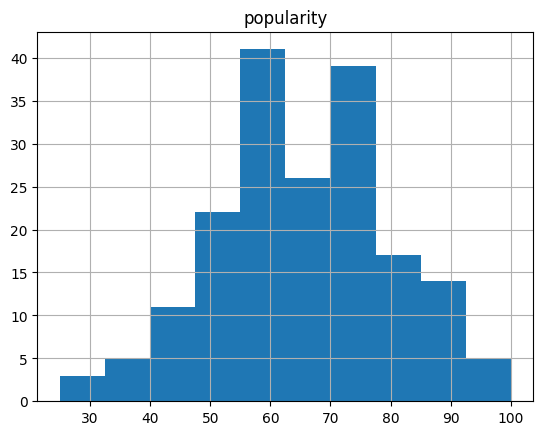

In [987]:
df.hist('popularity')

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

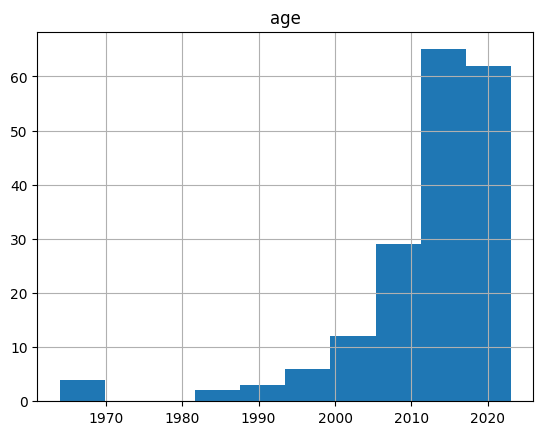

In [988]:
df.hist('age')

<AxesSubplot: ylabel='genres'>

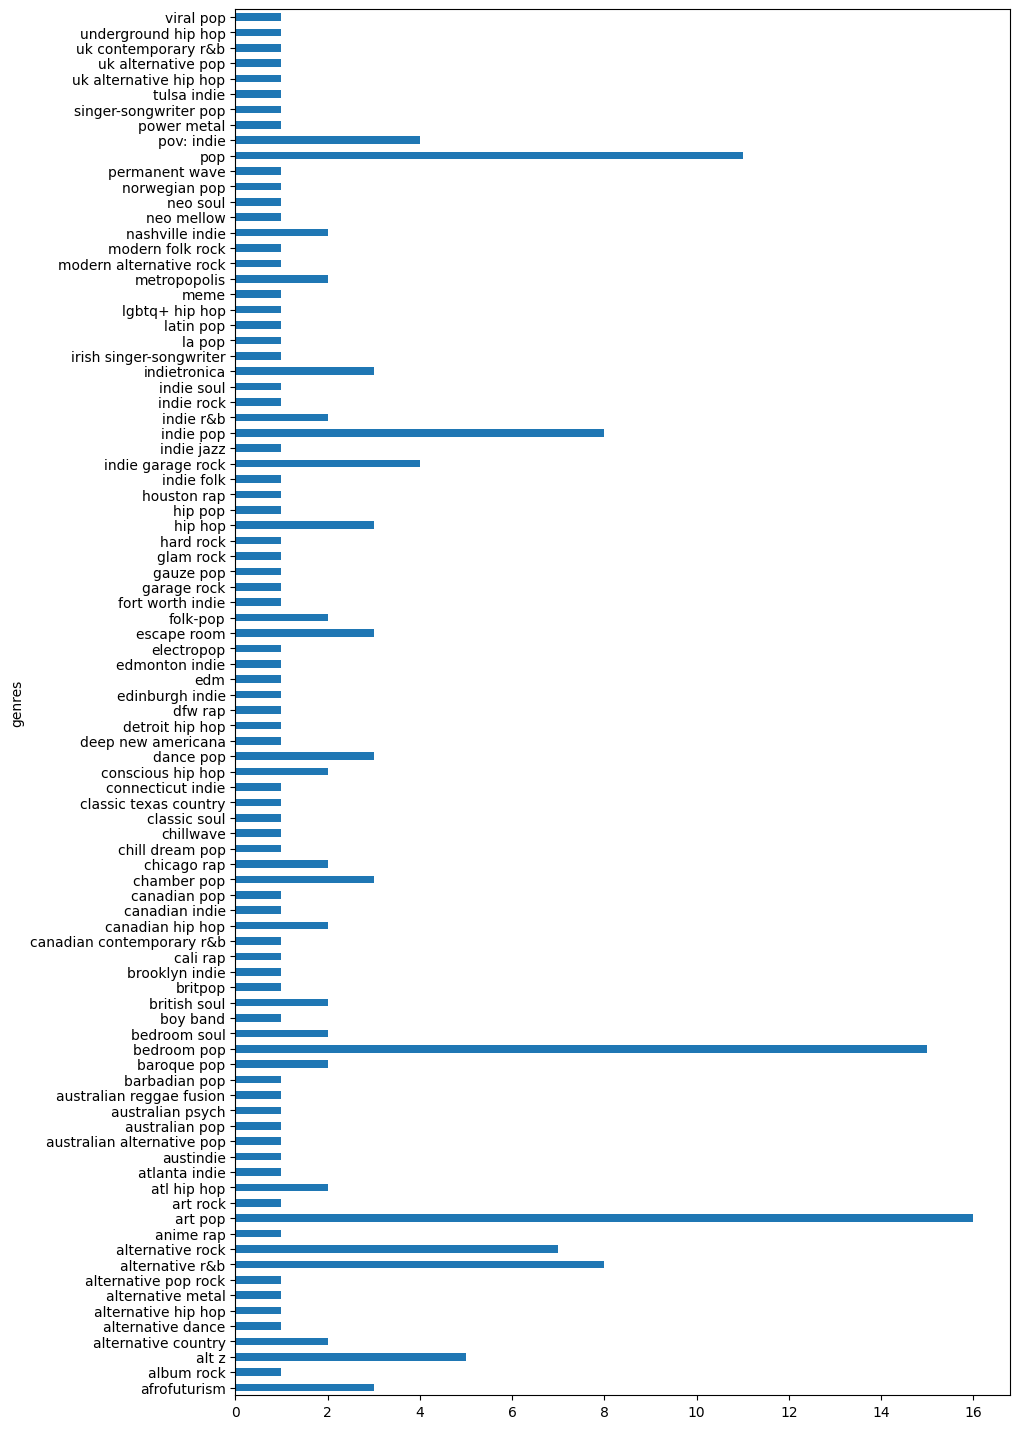

In [1013]:
df.groupby(['genres']).size().plot(kind='barh',figsize=(10,18))

# Data gathering
We now have:
1. A list of diverse artists who have played a live show at some point between September 2019 and September 2021
2. A function that pulls all the setlists in history for a given artist
3. A function that pulls all the songs on Spotify by a given artist
4. A function that pulls the top 10 tracks for a given artist

Time to aggregate!

In [1217]:
def all_data(artist_name):
    df_setlists = get_setlists(artist_name)
    df_songs = get_songs(artist_name)
    df_top_tracks = artist_top_tracks(artist_name)
    return df_setlists, df_songs, df_top_tracks

In [1218]:
test1,test2,test3 = all_data('sorcha richardson')

In [1949]:
test1 = get_setlists('sorcha richardson')

In [1933]:
test1

,artist,date,venue,setlist_id,tour,country,city,name,cover,cover_artist,played
0,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,hard to fake it,0,,1
1,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,spotlight television,0,,1
2,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,first prize bravery,0,,1
3,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,purgatory,0,,1
4,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,archie,0,,1
...,...,...,...,...,...,...,...,...,...,...,...
98,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,petrol station,0,,1
99,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,waking life,0,,1
100,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,false alarm,0,,1
101,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,twisting the knife,0,,1


In [1430]:
test2

,name,id,release_type,artist,album,popularity,release_date,track_number,audio_features
0,archie,1Pd44hn50S9zZtnp2YX1mY,album,sorcha richardson,smiling like an idiot,29,2022-09-23,1,"{'danceability': 0.514, 'energy': 0.486, 'key'..."
1,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,album,sorcha richardson,smiling like an idiot,31,2022-09-23,2,"{'danceability': 0.495, 'energy': 0.568, 'key'..."
2,spotlight television,5o5CADtcyCZFR2COk8EJ2g,album,sorcha richardson,smiling like an idiot,33,2022-09-23,3,"{'danceability': 0.542, 'energy': 0.574, 'key'..."
3,stalemate,1ETuzSEvD6P6WtJoOqVJI0,album,sorcha richardson,smiling like an idiot,21,2022-09-23,4,"{'danceability': 0.428, 'energy': 0.69, 'key':..."
4,purgatory,3kuF9mW9o4raA8olSKrBxU,album,sorcha richardson,smiling like an idiot,21,2022-09-23,5,"{'danceability': 0.562, 'energy': 0.629, 'key'..."
...,...,...,...,...,...,...,...,...,...
62,the first from me that's flown,2H0QGbLgSiXcLypZlmpYk6,single,sorcha richardson,last train,2,2013-09-29,2,"{'danceability': 0.446, 'energy': 0.255, 'key'..."
63,do you still,2NwQWiwCUBQlVHSRqctMUP,single,sorcha richardson,last train,7,2013-09-29,3,"{'danceability': 0.411, 'energy': 0.28, 'key':..."
64,last train - lexer remix,5rxznBLSP4avR1wC9Wzu9t,single,sorcha richardson,last train,3,2013-09-29,4,"{'danceability': 0.857, 'energy': 0.484, 'key'..."
65,do you still - rauschhaus remix,0Yu5RV6mYsTtcuaYUQQbP5,single,sorcha richardson,last train,3,2013-09-29,5,"{'danceability': 0.69, 'energy': 0.408, 'key':..."


In [1226]:
test3

,artist_id,name,id,track_order
0,04Zh21lNHZb2MCCcRcN2pc,ruin your night,6NVu0gFLV6t6SDjXUpwCeu,1
1,04Zh21lNHZb2MCCcRcN2pc,latch,2d1tlBbyST4TWmZ7xwdAXH,2
2,04Zh21lNHZb2MCCcRcN2pc,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,3
3,04Zh21lNHZb2MCCcRcN2pc,somebody told me,1NipBTZQXFIeQaqzy1Mdjj,4
4,04Zh21lNHZb2MCCcRcN2pc,first prize bravery,7juXOrLe6pu2Jz8EbiG67i,5
5,04Zh21lNHZb2MCCcRcN2pc,out the gaff,1HujLcfquU7tSd4ZHWj5OI,6
6,04Zh21lNHZb2MCCcRcN2pc,don't talk about it,3cXDxeOAB9a9GcKl2t3iHX,7
7,04Zh21lNHZb2MCCcRcN2pc,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,8
8,04Zh21lNHZb2MCCcRcN2pc,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,9
9,04Zh21lNHZb2MCCcRcN2pc,spotlight television,5o5CADtcyCZFR2COk8EJ2g,10


Great, we know it works. Also, since we're just appending to the tables in each, we can run it in a for loop and create long dataframes.

In [ ]:
for artist_name in musical_artists_combined:
    setlists, songs, top_tracks = all_data(artist_name)

# Data cleaning
As we can see, we have a tremendous amount of data cleaning to do.

### 1. Remove blank and incomplete setlists
Removing any setlists with 5 or less songs

In [1379]:
test1 = test1[test1['songs'].str.len() >= 5]

In [1380]:
# saving this table for future analysis
test1_all = test1

In [1381]:
test1

,artist,date,venue,setlist_id,songs,tour,country,city
2,sorcha richardson,17-06-2023,73d72689,3a60ddf,"[[hard to fake it, 0, ], [spotlight television...",,DE,mannheim
4,sorcha richardson,14-06-2023,63d01267,ba62dea,"[[hard to fake it, 0, ], [spotlight television...",,DE,münster
13,sorcha richardson,03-12-2022,4bd58f1e,63bf6ee3,"[[hard to fake it, 0, ], [spotlight television...",,IE,dingle
14,sorcha richardson,24-11-2022,5bd457c4,7bbfe68c,"[[hard to fake it, 0, ], [spotlight television...",eu / uk tour 2022,NL,amsterdam
20,sorcha richardson,13-05-2022,1bd639a4,23b72c93,"[[first prize bravery, 0, ], [high in the gard...",,NL,deventer
22,sorcha richardson,10-05-2022,4bd61f12,33b7d059,"[[first prize bravery, 0, ], [high in the gard...",,NL,nijmegen
23,sorcha richardson,31-03-2022,73d6ce55,4bb6b35e,"[[the starlight lounge, 0, ], [high in the gar...",,IE,dublin
24,sorcha richardson,11-01-2021,5bd63b88,3833d73,"[[first prize bravery, 0, ], [ruin your night,...",,IE,cork
25,sorcha richardson,28-04-2020,2bd63482,1b860530,"[[first prize bravery, 0, ], [high in the gard...",other voices presents courage - virtual gig - ...,IE,dublin
33,sorcha richardson,20-11-2019,2bd63482,439adf8f,"[[high in the garden, 0, ], [first prize brave...",,IE,dublin


### 2. Turn list of songs into individual rows
Also, expand song info into cover indicator and cover artist columns

In [1382]:
# turn list of songs into individual rows
test1 = test1.explode('songs',ignore_index=True)

In [1383]:
# expand out song column into more columns
test1[['song','cover','cover_artist']] = pd.DataFrame(test1.songs.tolist())

In [1384]:
# drop list song column
test1 = test1.drop('songs',axis=1)

In [1396]:
# adding ind that song was played at show for later join 
test1['played'] = 1
test1

,artist,date,venue,setlist_id,tour,country,city,song,cover,cover_artist,played
0,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,hard to fake it,0,,1
1,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,spotlight television,0,,1
2,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,first prize bravery,0,,1
3,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,purgatory,0,,1
4,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,archie,0,,1
...,...,...,...,...,...,...,...,...,...,...,...
98,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,petrol station,0,,1
99,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,waking life,0,,1
100,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,false alarm,0,,1
101,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,twisting the knife,0,,1


In [1418]:
test1_all['num_songs'] = test1_all['songs'].str.len()

/var/folders/z8/1tg30sb5613g5tjzkdfczjqc0000gn/T/ipykernel_55414/1503323960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1_all['num_songs'] = test1_all['songs'].str.len()


In [1419]:
test1_all

,artist,date,venue,setlist_id,songs,tour,country,city,num_songs
2,sorcha richardson,17-06-2023,73d72689,3a60ddf,"[[hard to fake it, 0, ], [spotlight television...",,DE,mannheim,9
4,sorcha richardson,14-06-2023,63d01267,ba62dea,"[[hard to fake it, 0, ], [spotlight television...",,DE,münster,14
13,sorcha richardson,03-12-2022,4bd58f1e,63bf6ee3,"[[hard to fake it, 0, ], [spotlight television...",,IE,dingle,8
14,sorcha richardson,24-11-2022,5bd457c4,7bbfe68c,"[[hard to fake it, 0, ], [spotlight television...",eu / uk tour 2022,NL,amsterdam,14
20,sorcha richardson,13-05-2022,1bd639a4,23b72c93,"[[first prize bravery, 0, ], [high in the gard...",,NL,deventer,7
22,sorcha richardson,10-05-2022,4bd61f12,33b7d059,"[[first prize bravery, 0, ], [high in the gard...",,NL,nijmegen,7
23,sorcha richardson,31-03-2022,73d6ce55,4bb6b35e,"[[the starlight lounge, 0, ], [high in the gar...",,IE,dublin,15
24,sorcha richardson,11-01-2021,5bd63b88,3833d73,"[[first prize bravery, 0, ], [ruin your night,...",,IE,cork,9
25,sorcha richardson,28-04-2020,2bd63482,1b860530,"[[first prize bravery, 0, ], [high in the gard...",other voices presents courage - virtual gig - ...,IE,dublin,6
33,sorcha richardson,20-11-2019,2bd63482,439adf8f,"[[high in the garden, 0, ], [first prize brave...",,IE,dublin,14


### 3. Expand audio features in song table

In [1431]:
# expand audio features list
audio_features_list = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness', 'liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature']
test2[audio_features_list] = pd.DataFrame(test2.audio_features.tolist())

In [1432]:
# drop unnecessary columns from audio features list
test2 = test2.drop(['audio_features','type','uri','track_href','analysis_url'],axis=1)

In [1433]:
test2

,name,id,release_type,artist,album,popularity,release_date,track_number,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,archie,1Pd44hn50S9zZtnp2YX1mY,album,sorcha richardson,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,-7.089,0,0.0275,0.0287,0.025300,0.0769,0.265,69.020,251360,4
1,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,album,sorcha richardson,smiling like an idiot,31,2022-09-23,2,0.495,0.568,...,-8.131,1,0.0347,0.0646,0.000037,0.1020,0.292,117.930,270293,4
2,spotlight television,5o5CADtcyCZFR2COk8EJ2g,album,sorcha richardson,smiling like an idiot,33,2022-09-23,3,0.542,0.574,...,-6.512,1,0.0283,0.3400,0.000027,0.1160,0.278,119.946,248547,4
3,stalemate,1ETuzSEvD6P6WtJoOqVJI0,album,sorcha richardson,smiling like an idiot,21,2022-09-23,4,0.428,0.690,...,-6.155,1,0.0374,0.0100,0.000002,0.2750,0.467,123.011,224507,4
4,purgatory,3kuF9mW9o4raA8olSKrBxU,album,sorcha richardson,smiling like an idiot,21,2022-09-23,5,0.562,0.629,...,-7.743,1,0.0376,0.5740,0.000021,0.2220,0.457,119.854,230893,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,the first from me that's flown,2H0QGbLgSiXcLypZlmpYk6,single,sorcha richardson,last train,2,2013-09-29,2,0.446,0.255,...,-9.728,0,0.0324,0.9190,0.000000,0.0968,0.200,126.161,154000,4
63,do you still,2NwQWiwCUBQlVHSRqctMUP,single,sorcha richardson,last train,7,2013-09-29,3,0.411,0.280,...,-12.509,1,0.0315,0.8690,0.001560,0.1090,0.151,148.023,364000,4
64,last train - lexer remix,5rxznBLSP4avR1wC9Wzu9t,single,sorcha richardson,last train,3,2013-09-29,4,0.857,0.484,...,-7.976,1,0.0501,0.0278,0.035500,0.0427,0.548,124.992,450500,4
65,do you still - rauschhaus remix,0Yu5RV6mYsTtcuaYUQQbP5,single,sorcha richardson,last train,3,2013-09-29,5,0.690,0.408,...,-9.022,1,0.0277,0.1690,0.047500,0.2240,0.324,85.016,368000,4


# Feature Engineering pt. 1

### 1. Popularity relative to catalogue mean
relative_popularity = 0.5 implies this song is 50% more popular than the average catalogue popularity

relative_popularity = 1 implies this song is twice as popular as the average catalogue popularity

relative_popularity = -1.5 implies this song is 150% less popular than the average catalogue popularity

In [1434]:
test2['relative_popularity'] = (test2['popularity'] - test2['popularity'].groupby(test2['artist']).transform('mean'))/test2['popularity'].groupby(test2['artist']).transform('mean')

In [1435]:
test2

,name,id,release_type,artist,album,popularity,release_date,track_number,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity
0,archie,1Pd44hn50S9zZtnp2YX1mY,album,sorcha richardson,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,0,0.0275,0.0287,0.025300,0.0769,0.265,69.020,251360,4,0.534755
1,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,album,sorcha richardson,smiling like an idiot,31,2022-09-23,2,0.495,0.568,...,1,0.0347,0.0646,0.000037,0.1020,0.292,117.930,270293,4,0.640600
2,spotlight television,5o5CADtcyCZFR2COk8EJ2g,album,sorcha richardson,smiling like an idiot,33,2022-09-23,3,0.542,0.574,...,1,0.0283,0.3400,0.000027,0.1160,0.278,119.946,248547,4,0.746445
3,stalemate,1ETuzSEvD6P6WtJoOqVJI0,album,sorcha richardson,smiling like an idiot,21,2022-09-23,4,0.428,0.690,...,1,0.0374,0.0100,0.000002,0.2750,0.467,123.011,224507,4,0.111374
4,purgatory,3kuF9mW9o4raA8olSKrBxU,album,sorcha richardson,smiling like an idiot,21,2022-09-23,5,0.562,0.629,...,1,0.0376,0.5740,0.000021,0.2220,0.457,119.854,230893,4,0.111374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,the first from me that's flown,2H0QGbLgSiXcLypZlmpYk6,single,sorcha richardson,last train,2,2013-09-29,2,0.446,0.255,...,0,0.0324,0.9190,0.000000,0.0968,0.200,126.161,154000,4,-0.894155
63,do you still,2NwQWiwCUBQlVHSRqctMUP,single,sorcha richardson,last train,7,2013-09-29,3,0.411,0.280,...,1,0.0315,0.8690,0.001560,0.1090,0.151,148.023,364000,4,-0.629542
64,last train - lexer remix,5rxznBLSP4avR1wC9Wzu9t,single,sorcha richardson,last train,3,2013-09-29,4,0.857,0.484,...,1,0.0501,0.0278,0.035500,0.0427,0.548,124.992,450500,4,-0.841232
65,do you still - rauschhaus remix,0Yu5RV6mYsTtcuaYUQQbP5,single,sorcha richardson,last train,3,2013-09-29,5,0.690,0.408,...,1,0.0277,0.1690,0.047500,0.2240,0.324,85.016,368000,4,-0.841232


<AxesSubplot: >

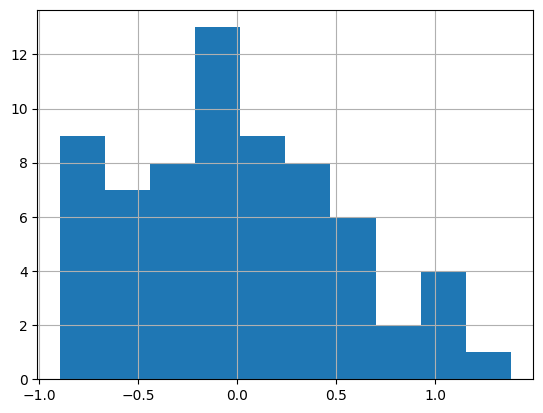

In [1436]:
test2['relative_popularity'].hist()

In [1437]:
test2.sort_values('relative_popularity').tail()

,name,id,release_type,artist,album,popularity,release_date,track_number,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity
38,out the gaff,1HujLcfquU7tSd4ZHWj5OI,single,sorcha richardson,out the gaff,37,2020-09-25,1,0.753,0.881,...,0,0.0859,0.2640,0.000293,0.1220,0.738,93.998,217320,4,0.958136
48,latch,2d1tlBbyST4TWmZ7xwdAXH,single,sorcha richardson,latch,39,2019-02-14,1,0.422,0.126,...,1,0.0854,0.9190,0.000000,0.1030,0.200,86.331,209819,3,1.063981
21,somebody told me,1NipBTZQXFIeQaqzy1Mdjj,single,sorcha richardson,somebody told me,39,2023-07-19,1,0.534,0.639,...,0,0.0955,0.3350,0.000560,0.0899,0.415,108.066,231243,4,1.063981
66,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,sorcha richardson,alone,39,2012-08-28,1,0.847,0.568,...,0,0.0893,0.0453,0.405000,0.6760,0.292,123.010,336016,4,1.063981
52,ruin your night,6NVu0gFLV6t6SDjXUpwCeu,single,sorcha richardson,ruin your night,45,2016-10-19,1,0.715,0.520,...,1,0.0265,0.3910,0.000000,0.0797,0.769,108.991,188411,4,1.381517


### 2. Number of times a song was released

In [1438]:
test2['num_released'] = test2['artist'].groupby(test2['name']).transform('count')

In [1439]:
test2

,name,id,release_type,artist,album,popularity,release_date,track_number,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released
0,archie,1Pd44hn50S9zZtnp2YX1mY,album,sorcha richardson,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,0.0275,0.0287,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3
1,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,album,sorcha richardson,smiling like an idiot,31,2022-09-23,2,0.495,0.568,...,0.0347,0.0646,0.000037,0.1020,0.292,117.930,270293,4,0.640600,3
2,spotlight television,5o5CADtcyCZFR2COk8EJ2g,album,sorcha richardson,smiling like an idiot,33,2022-09-23,3,0.542,0.574,...,0.0283,0.3400,0.000027,0.1160,0.278,119.946,248547,4,0.746445,1
3,stalemate,1ETuzSEvD6P6WtJoOqVJI0,album,sorcha richardson,smiling like an idiot,21,2022-09-23,4,0.428,0.690,...,0.0374,0.0100,0.000002,0.2750,0.467,123.011,224507,4,0.111374,1
4,purgatory,3kuF9mW9o4raA8olSKrBxU,album,sorcha richardson,smiling like an idiot,21,2022-09-23,5,0.562,0.629,...,0.0376,0.5740,0.000021,0.2220,0.457,119.854,230893,4,0.111374,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,the first from me that's flown,2H0QGbLgSiXcLypZlmpYk6,single,sorcha richardson,last train,2,2013-09-29,2,0.446,0.255,...,0.0324,0.9190,0.000000,0.0968,0.200,126.161,154000,4,-0.894155,2
63,do you still,2NwQWiwCUBQlVHSRqctMUP,single,sorcha richardson,last train,7,2013-09-29,3,0.411,0.280,...,0.0315,0.8690,0.001560,0.1090,0.151,148.023,364000,4,-0.629542,2
64,last train - lexer remix,5rxznBLSP4avR1wC9Wzu9t,single,sorcha richardson,last train,3,2013-09-29,4,0.857,0.484,...,0.0501,0.0278,0.035500,0.0427,0.548,124.992,450500,4,-0.841232,2
65,do you still - rauschhaus remix,0Yu5RV6mYsTtcuaYUQQbP5,single,sorcha richardson,last train,3,2013-09-29,5,0.690,0.408,...,0.0277,0.1690,0.047500,0.2240,0.324,85.016,368000,4,-0.841232,2


### 3. Single, album, and single + album indicators
After, need to remove duplicate songs. To do so, we are keeping the track_id with the highest popularity score for analysis.

In [1440]:
# if one specific row is album or single
test2['single_ind'] = np.where(test2['release_type']=='single', 1, 0)
test2['album_ind'] = np.where(test2['release_type']=='album', 1, 0)
# if one specific song is released ever as album or single
test2['single_ind_comp'] = np.where(test2[['artist','single_ind']].groupby(test2['name'])['single_ind'].transform('sum')>=1,1,0)
test2['album_ind_comp'] = np.where(test2[['artist','album_ind']].groupby(test2['name'])['album_ind'].transform('sum')>=1,1,0)
# if one specific song was released as both album and single
test2['album_single_ind'] = np.where(test2['single_ind_comp']+test2['album_ind_comp'] == 2, 1, 0)

In [1441]:
test2 = test2.drop(['single_ind','album_ind'],axis=1)

In [1442]:
test2

,name,id,release_type,artist,album,popularity,release_date,track_number,danceability,energy,...,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind
0,archie,1Pd44hn50S9zZtnp2YX1mY,album,sorcha richardson,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1
1,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,album,sorcha richardson,smiling like an idiot,31,2022-09-23,2,0.495,0.568,...,0.1020,0.292,117.930,270293,4,0.640600,3,1,1,1
2,spotlight television,5o5CADtcyCZFR2COk8EJ2g,album,sorcha richardson,smiling like an idiot,33,2022-09-23,3,0.542,0.574,...,0.1160,0.278,119.946,248547,4,0.746445,1,0,1,0
3,stalemate,1ETuzSEvD6P6WtJoOqVJI0,album,sorcha richardson,smiling like an idiot,21,2022-09-23,4,0.428,0.690,...,0.2750,0.467,123.011,224507,4,0.111374,1,0,1,0
4,purgatory,3kuF9mW9o4raA8olSKrBxU,album,sorcha richardson,smiling like an idiot,21,2022-09-23,5,0.562,0.629,...,0.2220,0.457,119.854,230893,4,0.111374,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,the first from me that's flown,2H0QGbLgSiXcLypZlmpYk6,single,sorcha richardson,last train,2,2013-09-29,2,0.446,0.255,...,0.0968,0.200,126.161,154000,4,-0.894155,2,1,0,0
63,do you still,2NwQWiwCUBQlVHSRqctMUP,single,sorcha richardson,last train,7,2013-09-29,3,0.411,0.280,...,0.1090,0.151,148.023,364000,4,-0.629542,2,1,0,0
64,last train - lexer remix,5rxznBLSP4avR1wC9Wzu9t,single,sorcha richardson,last train,3,2013-09-29,4,0.857,0.484,...,0.0427,0.548,124.992,450500,4,-0.841232,2,1,0,0
65,do you still - rauschhaus remix,0Yu5RV6mYsTtcuaYUQQbP5,single,sorcha richardson,last train,3,2013-09-29,5,0.690,0.408,...,0.2240,0.324,85.016,368000,4,-0.841232,2,1,0,0


In [1459]:
# since we're dropping duplicate rows, still want to make sure we have the earliest date of each release
test2['min_release_date'] = test2.groupby(['artist','name'])['release_date'].transform('min')

In [1461]:
# for each artist and song, keep only the specific release with the highest popularity
test2 = test2.sort_values('popularity',ascending=False).groupby(['artist','name'], as_index=False).first()

In [1462]:
test2

,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,...,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date
0,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,...,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07
1,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,...,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23
2,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,...,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28
3,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,...,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19
4,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25
5,sorcha richardson,butterflies,1RMvWA6XFFN8cciB2GHYFy,single,butterflies,22,2019-08-09,1,0.723,0.483,...,0.152,112.091,203973,4,0.164297,1,1,0,0,2019-08-09
6,sorcha richardson,can't we pretend,4ZVjxQunpIQgixtp8M2dOX,single,can't we pretend,18,2018-03-14,1,0.309,0.428,...,0.293,81.781,225533,4,-0.047393,1,1,0,0,2018-03-14
7,sorcha richardson,crush,4aycnQl3Q0GmnkkJR60UxC,single,crush,24,2019-06-14,1,0.696,0.238,...,0.482,97.888,185837,4,0.270142,1,1,0,0,2019-06-14
8,sorcha richardson,do you still,43RytCmeb9fEUFqDdKWVng,single,last train,13,2013-09-30,3,0.411,0.280,...,0.151,148.023,364000,4,-0.312006,2,1,0,0,2013-09-29
9,sorcha richardson,do you still - rauschhaus remix,21D7WowOYcx0k5fEX0llWz,single,last train,10,2013-09-30,5,0.690,0.408,...,0.324,85.016,368000,4,-0.470774,2,1,0,0,2013-09-29


### 4. Indicator if in top 5, top 3 tracks

In [1273]:
test3['top_10'] = np.where(test3['track_order'].isin(range(1,11)), 1, 0)
test3['top_5'] = np.where(test3['track_order'].isin(range(1,6)), 1, 0)
test3['top_3'] = np.where(test3['track_order'].isin(range(1,4)), 1, 0)
test3['top_1'] = np.where(test3['track_order'] == 1,1,0)

In [1277]:
test3

,artist_id,name,id,track_order,top 5,top 3,top 1,top 10
0,04Zh21lNHZb2MCCcRcN2pc,ruin your night,6NVu0gFLV6t6SDjXUpwCeu,1,1,1,1,1
1,04Zh21lNHZb2MCCcRcN2pc,latch,2d1tlBbyST4TWmZ7xwdAXH,2,1,1,0,1
2,04Zh21lNHZb2MCCcRcN2pc,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,3,1,1,0,1
3,04Zh21lNHZb2MCCcRcN2pc,somebody told me,1NipBTZQXFIeQaqzy1Mdjj,4,1,0,0,1
4,04Zh21lNHZb2MCCcRcN2pc,first prize bravery,7juXOrLe6pu2Jz8EbiG67i,5,1,0,0,1
5,04Zh21lNHZb2MCCcRcN2pc,out the gaff,1HujLcfquU7tSd4ZHWj5OI,6,0,0,0,1
6,04Zh21lNHZb2MCCcRcN2pc,don't talk about it,3cXDxeOAB9a9GcKl2t3iHX,7,0,0,0,1
7,04Zh21lNHZb2MCCcRcN2pc,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,8,0,0,0,1
8,04Zh21lNHZb2MCCcRcN2pc,shark eyes,1KYj6fNIUl7ESsnDTQhmhK,9,0,0,0,1
9,04Zh21lNHZb2MCCcRcN2pc,spotlight television,5o5CADtcyCZFR2COk8EJ2g,10,0,0,0,1


That's all the feature engineering we can do on the individual tables. Time to combine them together.

# Feature aggregation
Top 10 tracks table joins to song table on song id.

In [1463]:
song_df = pd.merge(test2,test3[['id','top 1','top 3','top 5','top 10','track_order']],on='id',how='left').fillna(0)

In [1464]:
song_df.head(5)

,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,...,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,top 1,top 3,top 5,top 10,track_order
0,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,...,1,1,0,0,2017-06-07,0.0,0.0,0.0,0.0,0.0
1,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,...,1,0,1,0,2022-09-23,0.0,0.0,0.0,0.0,0.0
2,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,...,1,1,0,0,2012-08-28,0.0,1.0,1.0,1.0,3.0
3,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,...,1,1,0,0,2023-07-19,0.0,0.0,0.0,0.0,0.0
4,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,...,3,1,1,1,2022-05-25,0.0,0.0,0.0,0.0,0.0


Setlist table joins to song table on artist name, song name. First, need to duplicate rows so we have list of all setlists, all songs:

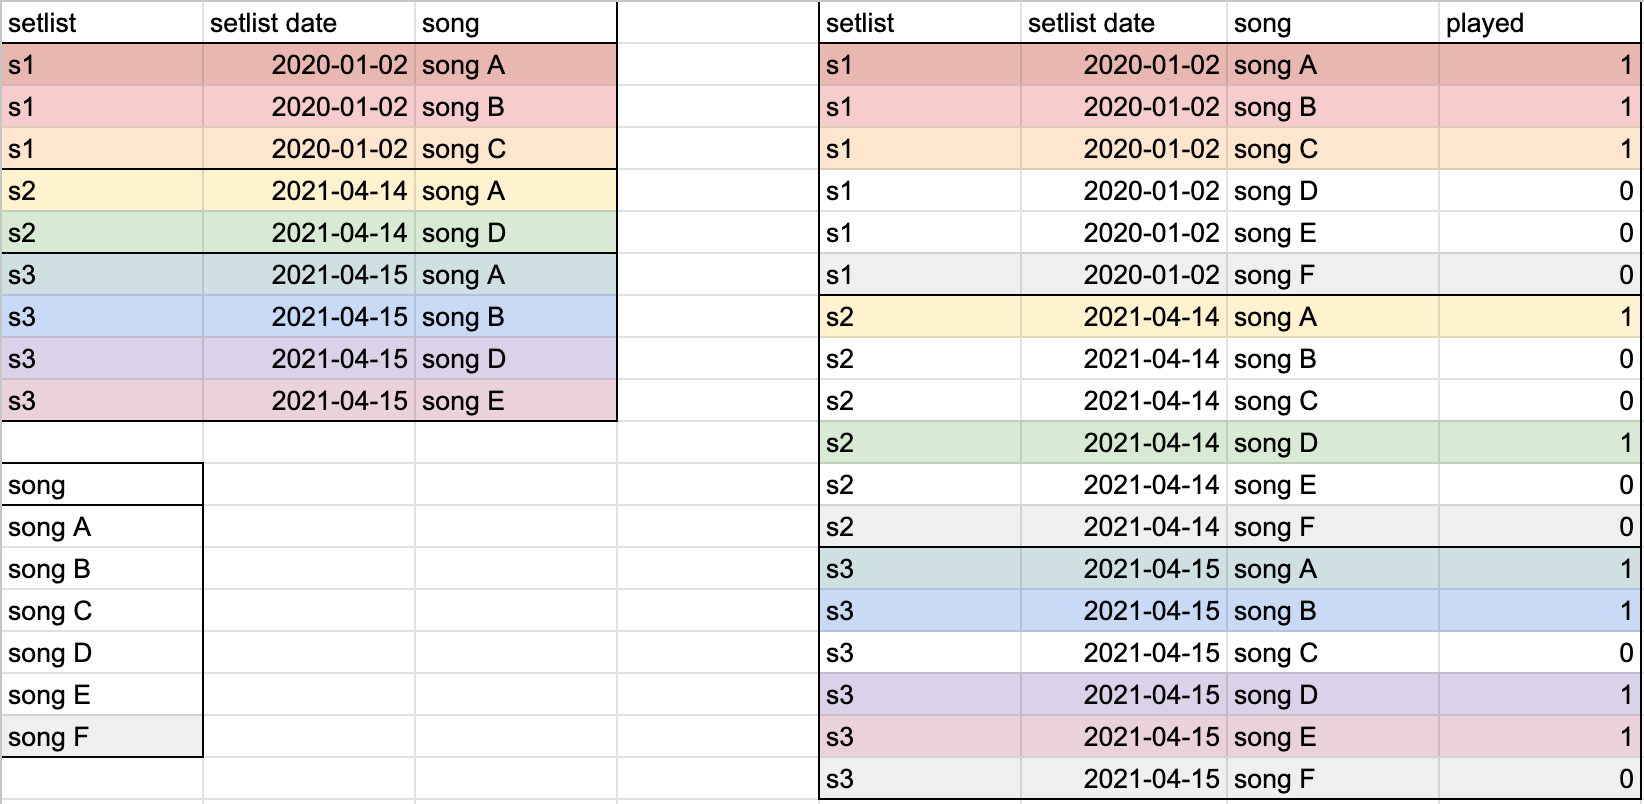

In [1465]:
all_songs_sets = pd.merge(test1_all[['setlist_id','date','venue','tour','country','city','num_songs']],test2,how='cross')

In [1466]:
all_songs_sets

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,...,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date
0,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,...,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07
1,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,...,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23
2,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,...,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28
3,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,...,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19
4,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,...,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,...,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13
506,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,...,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01
507,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,...,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08
508,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,...,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20


In [1644]:
test1

,artist,date,venue,setlist_id,tour,country,city,name,cover,cover_artist,played
0,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,hard to fake it,0,,1
1,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,spotlight television,0,,1
2,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,first prize bravery,0,,1
3,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,purgatory,0,,1
4,sorcha richardson,17-06-2023,73d72689,3a60ddf,,DE,mannheim,archie,0,,1
...,...,...,...,...,...,...,...,...,...,...,...
98,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,petrol station,0,,1
99,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,waking life,0,,1
100,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,false alarm,0,,1
101,sorcha richardson,20-11-2019,2bd63482,439adf8f,,IE,dublin,twisting the knife,0,,1


In [1407]:
# join setlist - songs played table to get flag of whether a song was played at a given show or not
test1 = test1.rename({'song':'name'},axis='columns')

In [1645]:
full_df = pd.merge(all_songs_sets,
                   test1[['name','played','setlist_id']],
                   on = ['name','setlist_id'],
                   how = 'left')

In [1646]:
# fill null values (played = NULL) with 0s (played = 0)
full_df = full_df.fillna(0)
# remove duplicates... not sure why some rows were duplicating. Pandas joins are not my friend I miss SQL
full_df = full_df.drop_duplicates(ignore_index=True)
full_df

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played
0,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0
1,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0
2,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0
3,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0
4,3a60ddf,17-06-2023,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,single,the starlight lounge,34,2020-11-13,1,0.830,0.345,2,-9.941,1,0.0445,0.37000,0.001580,0.1100,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13,0.0
506,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,single,the starlight lounge (live at the clinic),4,2021-01-01,1,0.580,0.272,2,-10.273,1,0.0303,0.54600,0.000000,0.1170,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01,0.0
507,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,album,first prize bravery,12,2019-11-08,9,0.707,0.545,0,-8.235,1,0.0293,0.80700,0.000358,0.1980,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08,1.0
508,439adf8f,20-11-2019,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,single,waking life,19,2017-09-20,1,0.538,0.542,8,-7.421,0,0.0376,0.06530,0.000000,0.1130,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20,1.0


In [1647]:
full_df.columns

Index(['setlist_id', 'date', 'venue', 'tour', 'country', 'city', 'num_songs',
       'artist', 'name', 'id', 'release_type', 'album', 'popularity',
       'release_date', 'track_number', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'relative_popularity', 'num_released', 'single_ind_comp',
       'album_ind_comp', 'album_single_ind', 'min_release_date', 'played'],
      dtype='object')

Amazing! We now have a table that has a list of all the setlists of every show an artist has played with details about the show, a list of all the songs an artist has played with details about the song, and an indicator for if each song was played at a given show.

# Feature Engineering pt. 2
Now that we have a feature-compiled table, there is more feature engineering work to do.

### 1. How many days since song release is show?
Also, was the song released after the show? This is why we created the min_release_date column earlier.

In [1648]:
# convert date columns to datetime
full_df['date'] = pd.to_datetime(full_df['date'],dayfirst=True)
full_df['min_release_date'] = pd.to_datetime(full_df['min_release_date'],yearfirst=True)

In [1649]:
# num days since release
full_df['days_since_release'] = (full_df['date']-full_df['min_release_date']).dt.days

In [1650]:
# ind if song was released before or after show
full_df['song_released'] = full_df['days_since_release'] > 0

In [1651]:
full_df

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,single,the starlight lounge,34,2020-11-13,1,0.830,0.345,2,-9.941,1,0.0445,0.37000,0.001580,0.1100,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13,0.0,-359,False
506,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,single,the starlight lounge (live at the clinic),4,2021-01-01,1,0.580,0.272,2,-10.273,1,0.0303,0.54600,0.000000,0.1170,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01,0.0,-408,False
507,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,album,first prize bravery,12,2019-11-08,9,0.707,0.545,0,-8.235,1,0.0293,0.80700,0.000358,0.1980,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08,1.0,12,True
508,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,single,waking life,19,2017-09-20,1,0.538,0.542,8,-7.421,0,0.0376,0.06530,0.000000,0.1130,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20,1.0,791,True


### 2. Has the song been played at previous shows?
This gets a little sketchy but I think it's still fine. First, need to create a table that has columns with setlist ids for the previous 5 shows.

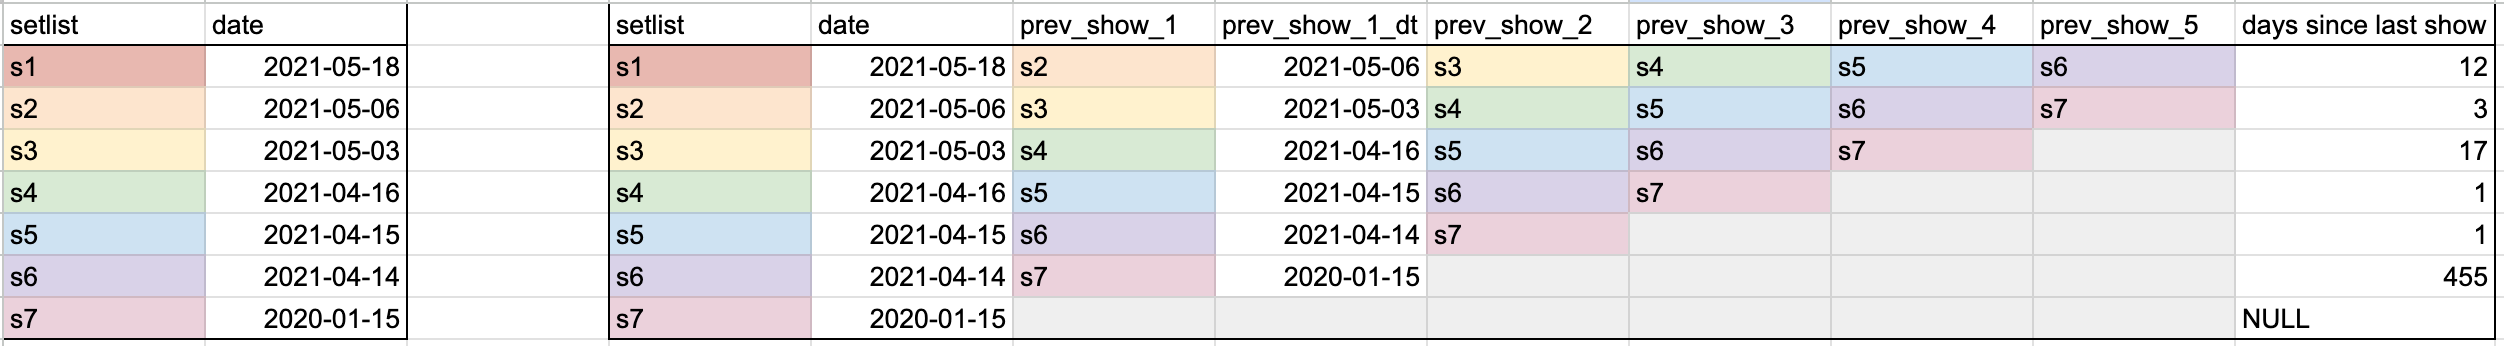

In [1542]:
test1_all['date'] = pd.to_datetime(test1_all['date'],dayfirst=True)

/var/folders/z8/1tg30sb5613g5tjzkdfczjqc0000gn/T/ipykernel_55414/366174272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1_all['date'] = pd.to_datetime(test1_all['date'],dayfirst=True)


In [1653]:
# sets should already be in decreasing date order, but just confirm
sets_date_order = test1_all.sort_values('date',ascending=False).reset_index(drop=True)

In [1952]:
test1['date'] = pd.to_datetime(test1['date'],dayfirst=True)
test1_blah = test1.sort_values('date',ascending=False).groupby('artist')

In [1953]:
test1_blah.head()

,artist,date,venue,setlist_id,songs,tour,country,city
0,sorcha richardson,2023-08-04,bd221f2,1ba46118,[],,IE,county waterford
1,sorcha richardson,2023-06-18,7bd7822c,3a66d2f,[],,IE,clonmellon
2,sorcha richardson,2023-06-17,73d72689,3a60ddf,"[[hard to fake it, 0, ], [spotlight television...",,DE,mannheim
3,sorcha richardson,2023-06-16,2bd01486,13a62d81,[],,DE,duisburg
4,sorcha richardson,2023-06-14,63d01267,ba62dea,"[[hard to fake it, 0, ], [spotlight television...",,DE,münster


In [1654]:
# create lists of setlist ids and dates
setlist_id_list = sets_date_order['setlist_id'].tolist()
setlist_date_list = sets_date_order['date'].tolist()

In [1655]:
# append null values to end of lists to account for if artist has less than 10 sets, prev sets will populate as blank
for x in range(len(sets_date_order)):
    setlist_id_list.append('')
setlist_date_list.append('')

In [1656]:
# create columns w ids for the previous 5 sets
sets_date_order['prev_set_1'] = setlist_id_list[1:len(sets_date_order)+1]
# create column w last show date
sets_date_order['prev_show_date'] = setlist_date_list[1:]
# create column w number days since last show
sets_date_order['days_since_last_show'] = (sets_date_order['date']-sets_date_order['prev_show_date']).dt.days

/var/folders/z8/1tg30sb5613g5tjzkdfczjqc0000gn/T/ipykernel_55414/4083829284.py:8: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  sets_date_order['prev_show_date'] = setlist_date_list[1:]


In [1657]:
sets_date_order

,artist,date,venue,setlist_id,songs,tour,country,city,num_songs,prev_set_1,prev_set_2,prev_set_3,prev_set_4,prev_set_5,prev_show_date,days_since_last_show
0,sorcha richardson,2023-06-17,73d72689,3a60ddf,"[[hard to fake it, 0, ], [spotlight television...",,DE,mannheim,9,ba62dea,63bf6ee3,7bbfe68c,23b72c93,33b7d059,2023-06-14,3.0
1,sorcha richardson,2023-06-14,63d01267,ba62dea,"[[hard to fake it, 0, ], [spotlight television...",,DE,münster,14,63bf6ee3,7bbfe68c,23b72c93,33b7d059,4bb6b35e,2022-12-03,193.0
2,sorcha richardson,2022-12-03,4bd58f1e,63bf6ee3,"[[hard to fake it, 0, ], [spotlight television...",,IE,dingle,8,7bbfe68c,23b72c93,33b7d059,4bb6b35e,3833d73,2022-11-24,9.0
3,sorcha richardson,2022-11-24,5bd457c4,7bbfe68c,"[[hard to fake it, 0, ], [spotlight television...",eu / uk tour 2022,NL,amsterdam,14,23b72c93,33b7d059,4bb6b35e,3833d73,1b860530,2022-05-13,195.0
4,sorcha richardson,2022-05-13,1bd639a4,23b72c93,"[[first prize bravery, 0, ], [high in the gard...",,NL,deventer,7,33b7d059,4bb6b35e,3833d73,1b860530,439adf8f,2022-05-10,3.0
5,sorcha richardson,2022-05-10,4bd61f12,33b7d059,"[[first prize bravery, 0, ], [high in the gard...",,NL,nijmegen,7,4bb6b35e,3833d73,1b860530,439adf8f,,2022-03-31,40.0
6,sorcha richardson,2022-03-31,73d6ce55,4bb6b35e,"[[the starlight lounge, 0, ], [high in the gar...",,IE,dublin,15,3833d73,1b860530,439adf8f,,,2021-01-11,444.0
7,sorcha richardson,2021-01-11,5bd63b88,3833d73,"[[first prize bravery, 0, ], [ruin your night,...",,IE,cork,9,1b860530,439adf8f,,,,2020-04-28,258.0
8,sorcha richardson,2020-04-28,2bd63482,1b860530,"[[first prize bravery, 0, ], [high in the gard...",other voices presents courage - virtual gig - ...,IE,dublin,6,439adf8f,,,,,2019-11-20,160.0
9,sorcha richardson,2019-11-20,2bd63482,439adf8f,"[[high in the garden, 0, ], [first prize brave...",,IE,dublin,14,,,,,,NaT,NaN


Now we want to determine if a song was played at the previous show. Some pseudo-code idea since this is a little sketchy...
1. sets_date_songs = sets_date_order left join full_df on prev_set_1 = setlist_id to get list of songs played at previous show. Need to make sure "played = 1" so that we are only getting actually played.
2. all_sets_prev_songs = full_df left join sets_date_songs on setlist_id = setlist_id to get list of songs played at current and previous show
3. if name == name, full_df['played_at_previous_show'] = 1

In [1658]:
sets_date_songs = pd.merge(sets_date_order[['setlist_id','prev_set_1']],full_df[['setlist_id','name','played']],left_on = 'prev_set_1', right_on = 'setlist_id', how='left').query('played == 1')


In [1659]:
sets_date_songs

,setlist_id_x,prev_set_1,setlist_id_y,name,played
4,3a60ddf,ba62dea,ba62dea,archie,1.0
14,3a60ddf,ba62dea,ba62dea,first prize bravery,1.0
16,3a60ddf,ba62dea,ba62dea,good intentions,1.0
17,3a60ddf,ba62dea,ba62dea,hard to fake it,1.0
18,3a60ddf,ba62dea,ba62dea,high in the garden,1.0
...,...,...,...,...,...
442,1b860530,439adf8f,439adf8f,petrol station,1.0
444,1b860530,439adf8f,439adf8f,red lion,1.0
445,1b860530,439adf8f,439adf8f,ruin your night,1.0
456,1b860530,439adf8f,439adf8f,twisting the knife,1.0


In [1660]:
all_sets_prev_songs = pd.merge(full_df[['setlist_id','name','played']],sets_date_songs[['setlist_id_x','name']],left_on='setlist_id',right_on='setlist_id_x',how='left').query('played == 1')

In [1661]:
same_name = []
for row in range(len(all_sets_prev_songs)):
    if all_sets_prev_songs['name_x'].iloc[[row]].item() == all_sets_prev_songs['name_y'].iloc[[row]].item():
        same_name.append(1)
    else:
        same_name.append(0)

In [1662]:
all_sets_prev_songs['played_at_prev'] = same_name

In [1663]:
all_sets_prev_songs = all_sets_prev_songs.query('played_at_prev == 1')

In [1664]:
all_sets_prev_songs = all_sets_prev_songs.rename(columns = {'name_x':'name'})

In [1665]:
# left join "played at prev" back onto full df
full_df.head()

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True


In [1666]:
full_df = pd.merge(full_df, all_sets_prev_songs[['played_at_prev','setlist_id','name']], on = ['setlist_id','name'], how = 'left')


In [1667]:
full_df = full_df.fillna(0)

In [1668]:
full_df.head()

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True,0.0
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True,0.0
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True,0.0
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False,0.0
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True,1.0


### 3. Of all the shows between when the song was released and this show, at what percent of shows has it been played?

In [1699]:
full_df.query('name == "high in the garden" & song_released == True')['played'][::-1].cumsum()[::-1]

18     8.0
69     8.0
120    7.0
171    7.0
222    6.0
273    5.0
324    4.0
375    3.0
426    2.0
477    1.0
Name: played, dtype: float64

In [1750]:
full_df['cum_sum'] = full_df.query('song_released == True').sort_values('date').groupby(['artist','name'])['played'].transform(pd.Series.cumsum)

In [1751]:
full_df.query('song_released == True').groupby(['artist','name'], as_index = False)['cum_sum'].max()

,artist,name,cum_sum
0,sorcha richardson,4am,2.0
1,sorcha richardson,525,2.0
2,sorcha richardson,alone - david k & lexer remix,0.0
3,sorcha richardson,archie,4.0
4,sorcha richardson,butterflies,0.0
5,sorcha richardson,can't we pretend,1.0
6,sorcha richardson,crush,0.0
7,sorcha richardson,do you still,0.0
8,sorcha richardson,do you still - rauschhaus remix,0.0
9,sorcha richardson,don't talk about it,0.0


In [1752]:
full_df = pd.merge(full_df,full_df.query('song_released == True').groupby(['artist','name'], as_index = False)['cum_sum'].max(),on = ['artist','name'],how = 'left')

In [1756]:
full_df = full_df.drop('cum_sum_y',axis = 1)
full_df = full_df.rename(columns = {'cum_sum_x':'num_times_played_prev'})

In [1761]:
full_df = full_df.fillna(0)
full_df

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True,0.0,2.0
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True,0.0,2.0
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True,0.0,0.0
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False,0.0,0.0
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,single,the starlight lounge,34,2020-11-13,1,0.830,0.345,2,-9.941,1,0.0445,0.37000,0.001580,0.1100,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13,0.0,-359,False,0.0,0.0
506,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,single,the starlight lounge (live at the clinic),4,2021-01-01,1,0.580,0.272,2,-10.273,1,0.0303,0.54600,0.000000,0.1170,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01,0.0,-408,False,0.0,0.0
507,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,album,first prize bravery,12,2019-11-08,9,0.707,0.545,0,-8.235,1,0.0293,0.80700,0.000358,0.1980,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08,1.0,12,True,0.0,1.0
508,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,single,waking life,19,2017-09-20,1,0.538,0.542,8,-7.421,0,0.0376,0.06530,0.000000,0.1130,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20,1.0,791,True,0.0,1.0


In [1780]:
# saving a copy just in case I fuck this up by accident somehow
full_df_save = full_df

Now adding on a column that shows, for each song, artist, the number of shows the song was released after. I.e. the number of shows at which the song hypothetically could have been played.

In [1882]:
full_df['num_shows'] = np.where(full_df['song_released']==False,0,1)

In [1885]:
full_df.query('name=="archie"')

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True,1.0,4.0,1
55,ba62dea,2023-06-14,63d01267,,DE,münster,14,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,385,True,1.0,3.0,1
106,63bf6ee3,2022-12-03,4bd58f1e,,IE,dingle,8,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,192,True,1.0,2.0,1
157,7bbfe68c,2022-11-24,5bd457c4,eu / uk tour 2022,NL,amsterdam,14,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,183,True,1.0,1.0,1
208,23b72c93,2022-05-13,1bd639a4,,NL,deventer,7,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,-12,False,1.0,0.0,0
259,33b7d059,2022-05-10,4bd61f12,,NL,nijmegen,7,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,-15,False,1.0,0.0,0
310,4bb6b35e,2022-03-31,73d6ce55,,IE,dublin,15,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,-55,False,0.0,0.0,0
361,3833d73,2021-01-11,5bd63b88,,IE,cork,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,0.0,-499,False,0.0,0.0,0
412,1b860530,2020-04-28,2bd63482,other voices presents courage - virtual gig - ...,IE,dublin,6,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,0.0,-757,False,0.0,0.0,0
463,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.0287,0.0253,0.0769,0.265,69.02,251360,4,0.534755,3,1,1,1,2022-05-25,0.0,-917,False,0.0,0.0,0


In [1886]:
full_df['num_shows_cum_sum'] = full_df.query('song_released == True').sort_values('date').groupby(['artist','name'])['num_shows'].transform(pd.Series.cumsum)


In [1890]:
full_df.query('name=="high in the garden"')

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum
18,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1317,True,0.0,8.0,1,10.0
69,ba62dea,2023-06-14,63d01267,,DE,münster,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1314,True,0.0,8.0,1,9.0
120,63bf6ee3,2022-12-03,4bd58f1e,,IE,dingle,8,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1121,True,0.0,7.0,1,8.0
171,7bbfe68c,2022-11-24,5bd457c4,eu / uk tour 2022,NL,amsterdam,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1112,True,1.0,7.0,1,7.0
222,23b72c93,2022-05-13,1bd639a4,,NL,deventer,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,917,True,1.0,6.0,1,6.0
273,33b7d059,2022-05-10,4bd61f12,,NL,nijmegen,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,914,True,1.0,5.0,1,5.0
324,4bb6b35e,2022-03-31,73d6ce55,,IE,dublin,15,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,874,True,1.0,4.0,1,4.0
375,3833d73,2021-01-11,5bd63b88,,IE,cork,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,430,True,1.0,3.0,1,3.0
426,1b860530,2020-04-28,2bd63482,other voices presents courage - virtual gig - ...,IE,dublin,6,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,172,True,1.0,2.0,1,2.0
477,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,12,True,0.0,1.0,1,1.0


Right now the cumulative number of shows is the total number including the current show, which is data leakage. Subtract one to get number of previous shows.

In [1891]:
full_df['num_shows_cum_sum'] = full_df['num_shows_cum_sum'] - 1

In [1892]:
full_df.query('name=="high in the garden"')

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum
18,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1317,True,0.0,8.0,1,9.0
69,ba62dea,2023-06-14,63d01267,,DE,münster,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1314,True,0.0,8.0,1,8.0
120,63bf6ee3,2022-12-03,4bd58f1e,,IE,dingle,8,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1121,True,0.0,7.0,1,7.0
171,7bbfe68c,2022-11-24,5bd457c4,eu / uk tour 2022,NL,amsterdam,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1112,True,1.0,7.0,1,6.0
222,23b72c93,2022-05-13,1bd639a4,,NL,deventer,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,917,True,1.0,6.0,1,5.0
273,33b7d059,2022-05-10,4bd61f12,,NL,nijmegen,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,914,True,1.0,5.0,1,4.0
324,4bb6b35e,2022-03-31,73d6ce55,,IE,dublin,15,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,874,True,1.0,4.0,1,3.0
375,3833d73,2021-01-11,5bd63b88,,IE,cork,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,430,True,1.0,3.0,1,2.0
426,1b860530,2020-04-28,2bd63482,other voices presents courage - virtual gig - ...,IE,dublin,6,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,172,True,1.0,2.0,1,1.0
477,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,12,True,0.0,1.0,1,0.0


Right now if a song is played at the current show, it's counted in num_times_played_prev, which is data leakage. Subtract whether or not the song was played to get number of previous shows at which it was played.

In [1894]:
full_df['num_times_played_prev'] = full_df['num_times_played_prev'] - full_df['played']

In [1895]:
full_df.query('name=="high in the garden"')

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum
18,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1317,True,0.0,8.0,1,9.0
69,ba62dea,2023-06-14,63d01267,,DE,münster,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1314,True,0.0,7.0,1,8.0
120,63bf6ee3,2022-12-03,4bd58f1e,,IE,dingle,8,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1121,True,0.0,7.0,1,7.0
171,7bbfe68c,2022-11-24,5bd457c4,eu / uk tour 2022,NL,amsterdam,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1112,True,1.0,6.0,1,6.0
222,23b72c93,2022-05-13,1bd639a4,,NL,deventer,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,917,True,1.0,5.0,1,5.0
273,33b7d059,2022-05-10,4bd61f12,,NL,nijmegen,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,914,True,1.0,4.0,1,4.0
324,4bb6b35e,2022-03-31,73d6ce55,,IE,dublin,15,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,874,True,1.0,3.0,1,3.0
375,3833d73,2021-01-11,5bd63b88,,IE,cork,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,430,True,1.0,2.0,1,2.0
426,1b860530,2020-04-28,2bd63482,other voices presents courage - virtual gig - ...,IE,dublin,6,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,172,True,1.0,1.0,1,1.0
477,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,12,True,0.0,0.0,1,0.0


In [1896]:
full_df = full_df.fillna(0)

Finally, we can include a column of the percentage of shows since its release at which a song was played.

In [1898]:
full_df['percent_played'] = np.where(full_df['num_shows_cum_sum']>0,
                                     full_df['num_times_played_prev']/full_df['num_shows_cum_sum'],
                                     0
                                    )

In [1900]:
full_df.query('name=="high in the garden"')

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum,percent_played
18,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1317,True,0.0,8.0,1,9.0,0.888889
69,ba62dea,2023-06-14,63d01267,,DE,münster,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1314,True,0.0,7.0,1,8.0,0.875000
120,63bf6ee3,2022-12-03,4bd58f1e,,IE,dingle,8,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,0.0,1121,True,0.0,7.0,1,7.0,1.000000
171,7bbfe68c,2022-11-24,5bd457c4,eu / uk tour 2022,NL,amsterdam,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,1112,True,1.0,6.0,1,6.0,1.000000
222,23b72c93,2022-05-13,1bd639a4,,NL,deventer,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,917,True,1.0,5.0,1,5.0,1.000000
273,33b7d059,2022-05-10,4bd61f12,,NL,nijmegen,7,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,914,True,1.0,4.0,1,4.0,1.000000
324,4bb6b35e,2022-03-31,73d6ce55,,IE,dublin,15,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,874,True,1.0,3.0,1,3.0,1.000000
375,3833d73,2021-01-11,5bd63b88,,IE,cork,9,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,430,True,1.0,2.0,1,2.0,1.000000
426,1b860530,2020-04-28,2bd63482,other voices presents courage - virtual gig - ...,IE,dublin,6,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,172,True,1.0,1.0,1,1.0,1.000000
477,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,high in the garden,72e7UirSPatU0CkvaOyHbI,album,first prize bravery,22,2019-11-08,7,0.67,0.751,9,-6.876,0,0.0637,0.19,0.000011,0.324,0.52,118.035,198587,4,0.164297,1,0,1,0,2019-11-08,1.0,12,True,0.0,0.0,1,0.0,0.000000


### 4. Number of days since the previous show?
This column already exists in sets_date_order, I think I just forgot to pull it in until now. Doing that.

In [1901]:
full_df = pd.merge(full_df,
                  sets_date_order[['setlist_id','days_since_last_show']],
                  on = 'setlist_id',
                  how = 'left')

### 5. Is it an album tour?
Some shows on setlist.fm have a "tour" description. If the album name is included in the tour, we indicate this. This probably isn't the best way to determine it, since some tours will not include the album name but still be based on that album, but this might provide a small bit of help.

In [1913]:
full_df['album_tour'] = full_df.apply(lambda x: x.album in x.tour, axis=1)

In [1914]:
full_df

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum,percent_played,days_since_last_show,album_tour
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True,0.0,2.0,1,9.0,0.222222,3.0,False
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True,0.0,2.0,1,3.0,0.666667,3.0,False
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True,0.0,0.0,1,9.0,0.000000,3.0,False
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False,0.0,0.0,0,0.0,0.000000,3.0,False
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True,1.0,3.0,1,3.0,1.000000,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,single,the starlight lounge,34,2020-11-13,1,0.830,0.345,2,-9.941,1,0.0445,0.37000,0.001580,0.1100,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13,0.0,-359,False,0.0,0.0,0,0.0,0.000000,NaN,False
506,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,single,the starlight lounge (live at the clinic),4,2021-01-01,1,0.580,0.272,2,-10.273,1,0.0303,0.54600,0.000000,0.1170,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01,0.0,-408,False,0.0,0.0,0,0.0,0.000000,NaN,False
507,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,album,first prize bravery,12,2019-11-08,9,0.707,0.545,0,-8.235,1,0.0293,0.80700,0.000358,0.1980,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08,1.0,12,True,0.0,0.0,1,0.0,0.000000,NaN,False
508,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,single,waking life,19,2017-09-20,1,0.538,0.542,8,-7.421,0,0.0376,0.06530,0.000000,0.1130,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20,1.0,791,True,0.0,0.0,1,0.0,0.000000,NaN,False


### 6. Population of the city in which the show was performed
It would take way too much work to manually determine number of seats in each venue, but I assume city population will serve as a rough proxy for this. Using the OpenDataSoft "Geonames - All Cities with a population > 1000" table for this information. Thank you ODS! (https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/export/?disjunctive.cou_name_en&sort=name)

In [1922]:
pop_df = pd.read_csv('geonames-all-cities-with-a-population-1000.csv',sep=";")

In [1925]:
# some basic data cleaning to get the same format as our set table
pop_df = pop_df.rename(columns = {'Name':'city', 'Country Code':'country', 'Population':'population'})
pop_df['city'] = pop_df['city'].str.lower()

In [1927]:
full_df = pd.merge(full_df,pop_df[['city','country','population']],on = ['city','country'],how = 'left')

In [1928]:
full_df

,setlist_id,date,venue,tour,country,city,num_songs,artist,name,id,release_type,album,popularity,release_date,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,relative_popularity,num_released,single_ind_comp,album_ind_comp,album_single_ind,min_release_date,played,days_since_release,song_released,played_at_prev,num_times_played_prev,num_shows,num_shows_cum_sum,percent_played,days_since_last_show,album_tour,population
0,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,4am,7yN1OgZ9PjgKUyAItPgVeF,single,4am,17,2017-06-07,1,0.278,0.578,4,-8.026,1,0.0445,0.09790,0.000129,0.1900,0.341,177.659,214973,4,-0.100316,1,1,0,0,2017-06-07,0.0,2201,True,0.0,2.0,1,9.0,0.222222,3.0,False,307960
1,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,525,2Oies0FwAeHrbfq8BftfbL,album,smiling like an idiot,17,2022-09-23,6,0.379,0.225,7,-15.074,1,0.0354,0.88000,0.003700,0.3470,0.440,153.745,179467,3,-0.100316,1,0,1,0,2022-09-23,0.0,267,True,0.0,2.0,1,3.0,0.666667,3.0,False,307960
2,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,alone - david k & lexer remix,6hH8CpyufV9n8ELJ6SIKhn,single,alone,39,2012-08-28,1,0.847,0.568,9,-9.175,0,0.0893,0.04530,0.405000,0.6760,0.292,123.010,336016,4,1.063981,1,1,0,0,2012-08-28,0.0,3945,True,0.0,0.0,1,9.0,0.000000,3.0,False,307960
3,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,"andy, you're a star",3zgOI2i0DwJLjQ6PVhBecX,single,somebody told me,24,2023-07-19,2,0.508,0.501,11,-7.945,0,0.0369,0.00301,0.000140,0.1520,0.277,93.889,167078,4,0.270142,1,1,0,0,2023-07-19,0.0,-32,False,0.0,0.0,0,0.0,0.000000,3.0,False,307960
4,3a60ddf,2023-06-17,73d72689,,DE,mannheim,9,sorcha richardson,archie,1Pd44hn50S9zZtnp2YX1mY,album,smiling like an idiot,29,2022-09-23,1,0.514,0.486,9,-7.089,0,0.0275,0.02870,0.025300,0.0769,0.265,69.020,251360,4,0.534755,3,1,1,1,2022-05-25,1.0,388,True,1.0,3.0,1,3.0,1.000000,3.0,False,307960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge,7kDWWJ3kyVjeqrG5LQLdSK,single,the starlight lounge,34,2020-11-13,1,0.830,0.345,2,-9.941,1,0.0445,0.37000,0.001580,0.1100,0.550,120.966,214306,4,0.799368,1,1,0,0,2020-11-13,0.0,-359,False,0.0,0.0,0,0.0,0.000000,NaN,False,1024027
608,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,the starlight lounge - live at the clinic,5pIMIfRN9QMCcTZuHDY1LS,single,the starlight lounge (live at the clinic),4,2021-01-01,1,0.580,0.272,2,-10.273,1,0.0303,0.54600,0.000000,0.1170,0.322,118.884,221405,4,-0.788310,1,1,0,0,2021-01-01,0.0,-408,False,0.0,0.0,0,0.0,0.000000,NaN,False,1024027
609,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,twisting the knife,0CmyT0d6dNovzdWk7GpJyj,album,first prize bravery,12,2019-11-08,9,0.707,0.545,0,-8.235,1,0.0293,0.80700,0.000358,0.1980,0.284,98.081,180773,4,-0.364929,1,0,1,0,2019-11-08,1.0,12,True,0.0,0.0,1,0.0,0.000000,NaN,False,1024027
610,439adf8f,2019-11-20,2bd63482,,IE,dublin,14,sorcha richardson,waking life,3Cnz5dYpo3gohkCI5BMTgO,single,waking life,19,2017-09-20,1,0.538,0.542,8,-7.421,0,0.0376,0.06530,0.000000,0.1130,0.227,100.242,241053,4,0.005529,1,1,0,0,2017-09-20,1.0,791,True,0.0,0.0,1,0.0,0.000000,NaN,False,1024027


There's more I might want to bring in eventually... but for now this is a great starting point. Time to condense, automate, and try to get into some modeling now that I have a basic framework in place.